#  San Francisco Muni Elevation Profiles

## Introduction
I ride SF Muni almost every day and love thinking about the characteristics of different bus routes - when they are busiest, what type of people ride them for what purposes, what neighborhoods do they go through, etc. I was excited to see that the Metropolitan Transportation Commission releases GIS data of all transit routes in the Bay Area. There are tons of really important ways that this data can be used. One of the most useful and practical ways I can think of is in terms of transporation planning / social justice issues. This dataset could be used to identify and quantify the public transit access in different neighborhoods as to see which areas are not serviced as well. 

However, for this analysis here I'm going to focus on something with perhaps less social impact - I'm going to look at the elevation profiles of Muni bus routes in San Francisco. Given the unique and hilly topography of San Francisco, I thought that this would be an interesting way to visualize bus routes through the city. In addition to the transit data from MTC, the other key dataset that I rely on is a shapefile of contour lines in San Francsico. I also use a shapefile of neighborhoods and a shapefile of streets to calculate some other interesting facts. These last 3 datasets are all publically available from SF OpenData. 

In addition to being a really interesting way to look at and compare bus lines, I use this notebook as a way to explore some of the open source GIS capablities of Python. I use spatial analytical tools in Shapely and Geopandas as well as some more general data wrangling in Pandas. I also will make some figures, demonstrating the use of matplotlib to plot data.

I found this to be a really interesting exercise both in terms of the subject matter and the tools and steps required to work with this data! If you're familiar with the transit in the area, you'll see that a lot of the results intuitively make sense, which is always a nice thing to see.

## Data Prep

In [1]:
#Import necessary modules
import pandas as pd
import geopandas as gpd
import os
import shapely
from shapely.geometry import *
import urllib
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import math
import pickle
%matplotlib inline

### Downloading Data

Since I'm going to be downloading a lot of spatial data (most of which is formatted the same), I first write a function that makes this easier to do. I then go ahead and download the 4 datasets that I mention above - transit lines, contour lines, neighborhood boundaries, and streets.

In [2]:
def download_unzip_shp(url, zip_name, shp, output_directory):
    file_name=output_directory+'/'+zip_name
    if not os.path.exists(file_name):
        urllib.urlretrieve(url,file_name)
    z=zipfile.ZipFile(file_name)
    extract_files=[x for x in z.namelist() if x.startswith(shp[:-3])]
    if not os.path.exists(output_directory+'/'+shp):
        z.extractall(output_directory, extract_files)
    del z
    return output_directory+'/'+shp

In [3]:
if not os.path.exists('Data'):
    os.mkdir('Data')

transit_shp=download_unzip_shp("http://www.mtc.ca.gov/maps_and_data/GIS/gisdata/Transit_DB_Shapefiles.zip", 
                               "Transit_DB_Shapefiles.zip",'Transit_Routes.shp', 'Data')

contour_shp=download_unzip_shp('http://apps.sfgov.org/datafiles/view.php?file=sfgis/phys_contours_wgs.zip', 
                               'phys_contours_wgs.zip','phys_contours_wgs.shp', 'Data')

neigh_shp=download_unzip_shp('https://data.sfgov.org/download/qc6m-r4ih/ZIP', "SFGovData.zip", 'planning_neighborhoods.shp',
                            'Data')
street_shp=download_unzip_shp('https://data.sfgov.org/download/wbm8-ratb/ZIP', 'stclines_streets.zip','stclines_streets.shp',
                             'Data')
print transit_shp
print contour_shp
print neigh_shp
print street_shp

Data/Transit_Routes.shp
Data/phys_contours_wgs.shp
Data/planning_neighborhoods.shp
Data/stclines_streets.shp


### Reading and Cleaning MUNI and Contour Datasets

Now that all the data is downloaded, I will start reading it in using Geopandas, starting with the transit data. I keep a variable called "CRS" which is the native coordinate system of the transit shapefile - EPSG 26910, which is NAD83 / UTM zone 9N. This projected coordinate system uses meters, which is important to keep in mind when we measure distances. All other spatial data will be projected into this coordinate system as well.

I subset the data for those transit lines under SFMTA and those that are buses. This represents MUNI!

In [4]:
transit=gpd.read_file(transit_shp)
CRS=transit.crs
print CRS
muni=transit[(transit.AGENCYNAME=='SF Municipal Transportation Agency')&(transit.CLASS=='Bus')].reset_index(drop=True)
muni=muni[['ASSET_NAME','geometry']]
muni.head()

{'init': u'epsg:26910'}


,ASSET_NAME,geometry
0,48th Avenue- Route: 38AX OB,LINESTRING (553045.0462999996 4182964.82599999...
1,Financial District- Route: 38ax IB,"LINESTRING (543198.1178000001 4181476.8808, 54..."
2,25th Avenue- Route: 38bx OB,LINESTRING (553045.0462999996 4182964.82599999...
3,Financial District- Route: 38bx IB,"LINESTRING (545371.8230999997 4181533.7753, 54..."
4,48th Avenue- Route: 38l OB,"LINESTRING (553160.7375999996 4182671.3609, 55..."


The dataset has a field "ASSET_NAME", which has the key information on bus route name and direction (inbound vs outbound). I will clean this up so it's standardized a bit, and create a multi-level index composed of bus route name and direction.

In [5]:
asset_split=muni['ASSET_NAME'].str.split(': ').str[1].str.upper()
muni['Name']=asset_split.str[:-3]
muni['Direction']=asset_split.str[-2:]
muni.drop('ASSET_NAME',1, inplace=True)
muni.set_index(['Name','Direction'], inplace=True)
muni[:8]

geometry
Name Direction                                                   
38AX OB         LINESTRING (553045.0462999996 4182964.82599999...
     IB         LINESTRING (543198.1178000001 4181476.8808, 54...
38BX OB         LINESTRING (553045.0462999996 4182964.82599999...
     IB         LINESTRING (545371.8230999997 4181533.7753, 54...
38L  OB         LINESTRING (553160.7375999996 4182671.3609, 55...
     IB         LINESTRING (543198.1178000001 4181476.8808, 54...
38   OB         LINESTRING (553160.7375999996 4182671.3609, 55...
     IB         LINESTRING (543148.8629999999 4180794.26679999...

Just to get a sense of what the data looks like...

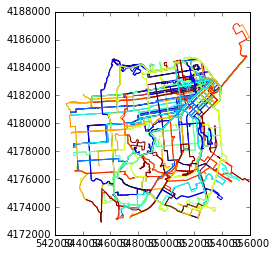

In [6]:
muni.plot()

Now that our muni data is dowloaded and compiled in a form that we can work with, I download the contour lines. These are a series of LineStrings that represent areas at that given elevation. This particular dataset is a 5 foot contour interval.

Looking at some basic descriptive statistics, we see that the mean elevation of the contour lines across the city is 230 feet with a minimum of -40 feet and a maximum of 915 feet.

In [7]:
contours=gpd.read_file(contour_shp)[['ELEVATION','geometry']].to_crs(CRS).rename(columns={'ELEVATION':'Elevation'})
contours.index.name='ContourID'
contours.head()

,Elevation,geometry
ContourID,,
0,-25,LINESTRING (555931.1898363371 4175557.64576668...
1,0,LINESTRING (552591.6374219519 4172758.57864942...
2,0,LINESTRING (553344.4027213481 4173159.48899935...
3,0,LINESTRING (552437.8647387434 4178143.05056517...
4,0,LINESTRING (542737.9951783345 4181475.13406148...


In [8]:
contours.Elevation.describe()

count    14151.000000
mean       230.884743
std        194.011825
min        -40.000000
25%         75.000000
50%        190.000000
75%        330.000000
max        915.000000
Name: Elevation, dtype: float64

## Bus Route Elevation Change

### Overlaying Bus Routes and Contour Lines

The next step is to overlay the contour lines and the bus lines as a way to determine the elevation at each of the data points along the bus routes. Rather than intersect all bus lines and contours at once, I'm going to focus on and write functions that deal with individual bus routes at a time. These functions can then be applied to the dataset as a whole, as we will see later on.

The function below takes as its input a Shapely LineString, overlays it with the contour lines, and returns a point at each intersection. These set of points represent our elevation data points along a particular bus route. In additiont to the elevation, I also calculate the distance from the start of the route (so that these points can be sorted in order), and the elevation change (the difference between the elevation of a point and the previous point). 

There are a few interesting analytical components of this function that are worth pointing out. First, a given contour line can intersect the same bus line more than once. Therefore some of the points in our initial GeoDataFrame will be multipoints. I write a function "multi_to_single" that converts multipoints to unique single data points (indexed by the same contour line).

Second, I use Shapely's `project` function to calculate the the intersection points distance along the bus route LineString. This is a really useful tool that will get used several times throughout this notebook. Lastly, once I have the distance along the bus line for each point, I can sort by this value and use the Pandas `diff` function to get the elevation change between points 

In [9]:
def get_line_elevation_points(bus_line_geo,contours):
    #Subset the contours that intersect the relevant bus route and then calculate the intersection points
    muni_x_contours=contours[contours.intersects(bus_line_geo)].intersection(bus_line_geo)
    
    #Write a function that converts multipoints to single points and apply it to the dataset
    def multi_to_single(row):
        if type(row)==MultiPoint:
            return pd.Series(list(row))
        if type(row)==Point:
            return pd.Series(row)
    elev_points=gpd.GeoDataFrame(geometry=muni_x_contours.apply(multi_to_single).stack())
    
    #Join the actual elevation data back to the dataset
    elev_points=elev_points.join(contours['Elevation'])
    
    #Calculate each points distance along the bus route and sort by this value
    elev_points['Dist']=elev_points['geometry'].apply(lambda x: bus_line_geo.project(x))
    elev_points=elev_points.sort('Dist').reset_index(drop=True)
    
    #Calculate elevation change
    elev_points['ElevChange']=elev_points['Elevation'].diff()
    return gpd.GeoDataFrame(elev_points,crs=CRS)

I now run the function on the geometry of the 33 Inbound bus. As you can see, we have a point at each intersection with a contour line with the associated elevation, distance from bus start, and elevation change.

In [10]:
get_line_elevation_points(muni.loc[('33','IB'),'geometry'],contours).head()

,geometry,Elevation,Dist,ElevChange
0,POINT (552248.7399841668 4178393.378070848),30,29.190577,NaN
1,POINT (552220.0660955727 4178418.443082587),35,82.833928,5
2,POINT (552217.9356084933 4178447.901113031),40,112.368899,5
3,POINT (552213.9509912564 4178502.996014569),45,167.607702,5
4,POINT (552210.1272263881 4178555.866894848),45,220.616675,0


These elevation points can be used to calculate all sorts of interesting things. For now, I will calculate the total elevation change, which is just the sum of the absolute value of the elevation change. Similarly, the elevation gain would just be the sum of the positive values, and the elevation loss would be the sum of the negative values. Elevation change gives a sense of the overall 'hilliness' of a route and is what I will use going forward. Below I calculate elevation points and the elevation gain (in feet) for the 1 Inbound in one line of code.

In [11]:
print get_line_elevation_points(muni.loc[('1','IB'),'geometry'],contours)['ElevChange'].abs().sum()

1205.0


Now that we have a function that calculates the elevation points for a bus line, I can easily apply that function to the entire muni dataset and calculate the elevation change for each bus line and each direction. It takes a couple minutes to run, so I've saved the output so that I don't have to calculate it each time I run the code.

In [12]:
elev_change_out='muni_elev_change.csv'
if not os.path.exists(elev_change_out):
    muni_elevation_change=muni['geometry'].apply(lambda x:get_line_elevation_points(x, contours)['ElevChange'].abs().sum())
    muni_elevation_change.name='ElevChange'
    muni_elevation_change.reset_index().to_csv('muni_elev_change.csv',index=False)
else:
    muni_elevation_change=pd.read_csv('muni_elev_change.csv',index_col=['Name','Direction'])['ElevChange']

Would expect inbound and outbound routes to have the same total elevation change, but the same exact route is not taken (because of one-way streets), which explains for the differences shown with the different 38 bus lines below.

In [13]:
muni_elevation_change[:6]

Name  Direction
38AX  OB            850
      IB           1040
38BX  OB            610
      IB            690
38L   OB           1000
      IB            945
Name: ElevChange, dtype: float64

In [14]:
print muni_elevation_change.idxmax(),muni_elevation_change.max()
print muni_elevation_change.idxmin(),muni_elevation_change.min()

('91', 'IB') 4240.0
('80X', 'IB') 80.0


We can also look at the maximum and minimum elevation change of all the bus routes. However, being familar with these two routes I know that the 91 is a very long bus route and the 80x is a very short route. It'd probably be more interesting to look at the elevation change per mile as a way to see which routes are really the hilliest and the flattest.

This list below makes a lot more sense. Here I aggregate the inbound and outbound bus lines together and calculate the elevation change per mile across the entire route. The 3 cable car lines which go up Nob Hill are all in the top 5, which should not be suprising to anyone that's ridden these. The 35 and the 36 go up along the east and west sides of Twin Peaks, which explains why they are on this list.

In [15]:
full_route_length=(muni.length/1609.34).groupby(level='Name').sum()
full_route_elev_change=muni_elevation_change.groupby(level='Name').sum()

elev_change_per_mile=(full_route_elev_change/full_route_length)
elev_change_per_mile.sort(inplace=False,ascending=False).head()


Name
POWELL-HYDE     421.212388
35              370.737733
POWELL-MASON    325.903532
CALIFORNIA      282.808092
36              271.951503
dtype: float64

## Bus Route Neighborhood Composition

Okay now that I've calculated elevation points and elevation change, I'm going to take this in a slightly different direction. I'm going to look at neighborhood boundaries in the city and see what neighborhoods that bus routes pass through at what points. I've already downloaded my neighborhood boundaries shapefile from the city website, and I read it in and then plot it below.

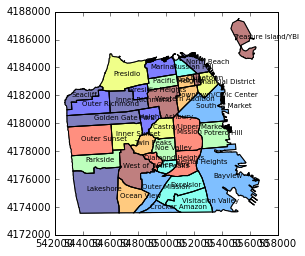

In [16]:
neighs=gpd.read_file(neigh_shp)
neighs=neighs.to_crs(CRS)
neighs.plot()
for i, row in neighs.iterrows():
    Label=row['neighborho']
    X=row['geometry'].centroid.x
    Y=row['geometry'].centroid.y
    plt.annotate(Label, xy=(X,Y), size=7, xytext=(-10,0), textcoords='offset points') 

Next I want to be able to intersect a given busline with the neighborhoods and get a segment within each neighborhood as well as the point at which the bus line "switches" neighborhoods. I write a function to do this below.

One key piece of information that I want is the distance along a bus route at which point it switches neighborhoods. In addition to allowing me to have the correct order of neighborhoods (which neighborhood a bus starts in and which neighborhood a bus ends in), it will also allow me to make some interesting plots as will be shown later.

Getting the distance of each "switch-point" is pretty straightforward as can be seen below. First the starting point of each line segment needs to be extracted (being sure to account for both multipart and singlepart geometries) and then the project function in shapely is used to get the distance of this point along the bus line.

In [17]:
def get_bus_neigh_intersection(bus_line_geo, neighs):
    #first get the subset of neighborhoods actually intersect the bus route
    relevant_neighs=neighs[neighs.intersects(bus_line_geo)]
    #create a new GeoDataFrame where the data is the neighborhood and the geometry 
    #is the intersection of the bus line and neighborhood
    lineXneigh=gpd.GeoDataFrame(data=relevant_neighs,geometry=relevant_neighs['geometry']\
                                .apply(lambda row: bus_line_geo.intersection(row)))
    
    #function that identifies the starting point of each of these line segments. 
    #This is the point at which a bus route switches neighborhoods
    #Need to account for both Single and Multipart geometries
    def start_point(row):
        if type(row)==LineString:
            return Point(list(row.coords)[0])
        if type(row)==MultiLineString:
            return Point([list(x.coords) for x in list(row)][0][0])
    #Apply this function to get the "switching" point of each bus segment and then use 
    #project to get the distance along the route    
    start_distance=lineXneigh.geometry.apply(start_point).apply(lambda x:bus_line_geo.project(x))
    lineXneigh['start_distance']=start_distance
    return lineXneigh.sort('start_distance').reset_index(drop=True)

I run this function on the 38 IB bus line below and the output is as we would expect. The bus starts in the Outer Richmond and ends in the Financial district. If I ran the function on the outbound bus route, the neighborhood order would be reversed.

In [18]:
get_bus_neigh_intersection(muni.loc[('38','IB'),'geometry'],neighs)

,geometry,neighborho,start_distance
0,(LINESTRING (543148.8629999999 4180794.2667999...,Outer Richmond,0.000000
1,(LINESTRING (545939.756382154 4181572.68921196...,Inner Richmond,3705.582208
2,LINESTRING (547649.7549860827 4181680.75735550...,Presidio Heights,5479.587075
3,(LINESTRING (548657.3349755615 4181799.0710392...,Western Addition,6496.081302
4,LINESTRING (550975.870708686 4181989.418030304...,Downtown/Civic Center,9387.312089
5,LINESTRING (552265.4847231681 4182313.74089443...,Financial District,11029.476944


A natural extension of this function might be to plot the proportion of a bus route's length spent in each neighborhood. I write a function below that wraps this function and creates a pie chart showing the results. I run it on two different bus lines, the 33 IB and the 38 IB below.

In [19]:
def plot_neigh_pct(bus_line_geo,neighs):
    bXn=get_bus_neigh_intersection(bus_line_geo, neighs)
    proportion_neigh=bXn.length/bXn.length.sum()
    plt.pie(proportion_neigh,labels=bXn['neighborho'],
        autopct='%1.1f%%', startangle=90, counterclock=False)
    plt.axis('equal')
    plt.show()

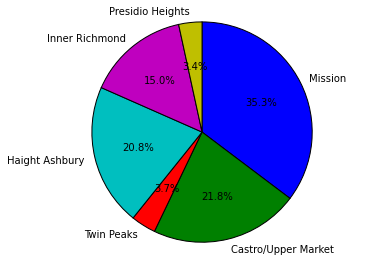

In [20]:
plot_neigh_pct(muni.loc[('33','IB')]['geometry'],neighs)

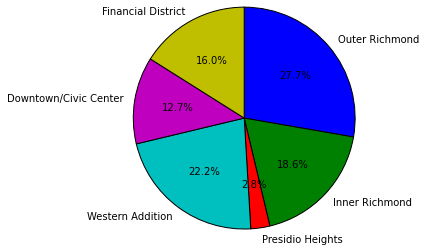

In [21]:
plot_neigh_pct(muni.loc[('38','IB')]['geometry'],neighs)

## Plot Elevation Profiles
Another interesting way to use this data is to create elevation profiles for different bus lines. The function allows the user to specify a bus line and creates an elevation profile that also uses the neighborhood data to plot neighborhood boundaries. The function uses the previously definited functions to calculate elevation points and neighborhood starting points. I then apply the function to the 38 Inbound line.


In [22]:
def plot_fig(bus_line, muni, neighs, contours):
    bus_line_geo=muni.loc[bus_line,'geometry'] #extract the bus line geography from the muni dataset
    elev_points=get_line_elevation_points(bus_line_geo, contours) #calculate the elevation points
    neighstarts=get_bus_neigh_intersection(bus_line_geo,neighs) #calculate the neighborhood intersections
    
    fig, ax = plt.subplots(figsize=(12, 2)) #define the plot size
    ax.plot(elev_points['Dist'], elev_points['Elevation']) #plot distance on the x-axis, elevation on the y-axis
    
    #define the axis properties - intervals, margins, and limits
    ax.locator_params(axis='y', nbins=4, steps=range(1, 11))
    ax.locator_params(axis='x', nbins=5, steps=range(1, 11)) 
    ax.margins(x=0, y=1)
    ax.set_ylim(bottom=-100, top=elev_points.Elevation.max()+750)
    
    ax.set(xlabel='Distance (ft)', ylabel='Elevation', aspect=1) # Set the aspect of the plot to be equal and add some x/y labels

    ElevChangeNum=elev_points['ElevChange'].abs().sum() #Calculate the elevation change
    FtPerMile=ElevChangeNum/(bus_line_geo.length/1609.34) #Calculate the elevation change per mile
    
    #Add a title to the plot
    Title=bus_line[0]+' '+bus_line[1]+': '+str(int(ElevChangeNum))+ ' ft change ('+str(int(FtPerMile))+' ft per mi)'
    ax.set_title(Title)
    
    #Loop through the neighborhoods that the bus passes through
    #Plot a vertical line and neighborhood name at the start point of each
    for i, row in neighstarts.iterrows():
        ax.plot((row['start_distance'], row['start_distance']), (ax.get_ylim()[0], ax.get_ylim()[1]), color='black')
        Text= '\n'.join(row['neighborho'].split(' '))        
        ax.annotate(Text, size=8, xy=(row['start_distance'],ax.get_ylim()[1]), xytext=(5,-20), textcoords='offset points')
    plt.show()

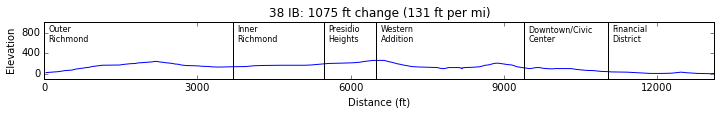

In [23]:
plot_fig(('38','IB'), muni, neighs,contours)

##  Cross Streets of Max and Min Elevation

One more really useful information in helping to visualize these bus lines would be some information on cross-streets as to give a better sense of where exactly the bus is at the high and low points along a route. Using a shapefile of San Francisco streets I can do precisely that. The overall methodology is to use the streets shapefile to find the closest street segment that is perpendicular to the bus line at the maximum and minimum elevation points. I found this exercise in itself to be a really a really interesting way to make use of geospatial tools in Python that showcases their flexibility in answering spatial questions.

First I read in the shapefile of street segments and do some basic cleaning of the geometry and the street name.

In [24]:
streets=gpd.read_file(street_shp)[['STREET', 'geometry']] 
streets=streets.to_crs(CRS)
#The coordinates have z value which we will get rid of
streets['geometry']=streets['geometry'].apply(lambda row:LineString([y[0:2] for y in list(row.coords)]))
streets['STREET']=streets.STREET.apply(lambda x: x.title())
streets.index.name='StreetID'
print streets.head()
print len(streets)

                 STREET                                           geometry
StreetID                                                                  
0                 Crown  LINESTRING (548716.8034123355 4179023.59401420...
1         Saint Germain  LINESTRING (548546.1921929531 4179056.69485356...
2                Corona  LINESTRING (547005.221351696 4175540.363632607...
3            West Point  LINESTRING (554541.9496987708 4176699.78871007...
4               Fairfax  LINESTRING (554554.0035907698 4176735.73245109...
14968


There are 14,968 LineStrings in that Shapefile. These generally represent the segment of a street between which it intersects other streets. However, given that I am going to be looking at the angles of street segments in relation to the Muni line (in order to identify the cross street), I am interested in each individual straight line segment. I break street segments into their individual components with the function below.

In [25]:
def get_line_segments(row):
    coords=list(row.coords)
    return pd.Series([LineString([coords[i], coords[i+1]]) for i in range(len(coords)-1)])
street_segments=gpd.GeoDataFrame(geometry=streets['geometry']\
                                 .apply(get_line_segments).stack(), crs=CRS).join(streets['STREET']).reset_index(drop=True)
print street_segments.head()
print len(street_segments)

                                            geometry         STREET
0  LINESTRING (548716.8034123355 4179023.59401420...          Crown
1  LINESTRING (548743.346451962 4179021.141489736...          Crown
2  LINESTRING (548546.1921929531 4179056.69485356...  Saint Germain
3  LINESTRING (547005.221351696 4175540.363632607...         Corona
4  LINESTRING (547010.4135687321 4175549.67535376...         Corona
32089


There are now 32,089 unique street segments. As you can see, the original LineString for "Crown" street was broken up into two segments and now appears as two unique rows. Essentially if we started with one street `LineString([(0,0),(1,1),(1,2)])`, it is broken up into two separate segments with this function: `LineString([(0,0),(1,1)])` and `LineString([(1,1),(1,2)])`

### Calculating the angle between Two Line Segments
Now that we have these unique street segments, the next step is to identify the one that is perpendicular to the bus line at the minimum and maximum points of the bus route. Before we do that, we will need a function that will calculate the angle between two line segments. I write the following function below and then show an example of it being applied to sample data. The function relies on some basic vector algebra, which I will go through below.

I will first convert the two line segments that are being compared to vectors. Then I use two theorems in vector algebra to calculate the angle between these two vectors. The first is that the dot product of two vectors equals the product of the vector magnitudes multiplied by the cosine of the angle between them:

$$\vec a\cdot \vec b = \lVert \vec a \rVert \lVert \vec b \rVert  cos\theta \ $$




And second is that the dot product of a vector with itself equals the square root of the magnitude of the vector. 

$$\vec u \cdot \vec u = \lVert \vec u \rVert^2 $$

Using these two formulas, we can solve for the angle between them as follows:

$$ \theta = \arccos(\frac{\vec a\cdot \vec b}{\sqrt {\vec a \cdot \vec a} \times \sqrt {\vec b \cdot \vec b}}) $$

Calculating all of this is pretty easy with functions in the `numpy` and `math` modules.



106.69924423399362

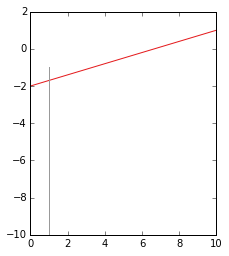

In [26]:
def get_angle_degrees(lineA, lineB):    
    
    #Convert lines to vectors
    vA = [(lineA[0][0]-lineA[1][0]), (lineA[0][1]-lineA[1][1])]
    vB = [(lineB[0][0]-lineB[1][0]), (lineB[0][1]-lineB[1][1])]
    
    dotprod=np.inner(vA,vB) #Calculate dot product of the two vectors

    #calculate magnitude of each vector
    magA=np.sqrt(np.inner(vA,vA))
    magB=np.sqrt(np.inner(vB,vB))
    
    #Calculate angle as the arccos of the dot product divided by the product of the vector magnitudes
    angle = math.acos(dotprod/(magA*magB))
    
    angdeg = math.degrees(angle)%360 #Convert angle to degrees
    return angdeg

line1=[[0,-2],[10,1]]
line2=[[1,-1],[1,-10]]
gpd.GeoSeries([LineString(line1),LineString(line2)]).plot()

get_angle_degrees(line1, line2)

Using the two sample lines above, we can see that the newly defined function calculates the angle between them as 106 degrees.


### Calculating the Nearest Cross Street
Now that I've defined these functions, I'm ready to write a function that calculates the nearest cross-street to a point along the bus route. The function uses the `get_angle_degrees` function defined above to calculate the angles between the muni segment that the point lies on and each of the street segments. I then return the closest street that is between 85 and 95 degrees (my arbitrary definition of cross-street) of the muni route at that point. 

In [29]:
def nearest_cross_street(point_along_route, bus_line, streets, muni):
    #get the individual straight line muni segments and individual straight line street segments
    muni_line_segments=gpd.GeoSeries(get_line_segments(muni.loc[bus_line,'geometry'])) 
    street_segments=gpd.GeoDataFrame(geometry=streets['geometry'].apply(get_line_segments).stack(), crs=CRS)
    street_segments=street_segments.join(streets['STREET']).reset_index(drop=True) #join back to get the street name
    
    #identify the muni segment that the point lies on
    muni_line_segment=muni_line_segments[muni_line_segments.intersects(point_along_route.buffer(1))].iloc[0]
    
    #only calculate the angles on street segments within 500  meters of the point, just to speed it up
    possible_street_segments=street_segments[street_segments.distance(point_along_route)<500].reset_index()
    #calculate angles between each of the street segments and the muni line segment that the point is on
    angles=possible_street_segments.geometry.apply(lambda x:get_angle_degrees(list(x.coords), list(muni_line_segment.coords)))
    #define cross-streets as those between 85 and 95 degrees
    cross_angles=(angles>85)&(angles<95)
    #return the closest street that is between 85 and 95 degrees of the muni line at that point.
    return str(gpd.GeoDataFrame(possible_street_segments[cross_angles]).set_index('STREET').distance(point_along_route).idxmin())

Below, I show an example where I calculate the point exactly halfway along the 38 outbound and then use the function defined above to find the nearest cross-street to this point. 

In [30]:
examp_38=muni.loc[('38','OB')]['geometry']
mid_way=examp_38.interpolate(examp_38.length/2)
nearest_cross_street(mid_way, ('38','OB'), streets, muni)

'Presidio'

Now I write a function that wraps the previous function and calculates the cross street at the maximum and minimum elevation points of a bus line. I then apply it to a bus route (the 1 inbound) and see that the maximum elevation is at Jones St (on top of Nob Hill) and the minimum is at Front Street (near the ferry building). Note that if there are multiple points that share the max or min values, the nearest cross street is calculated from the first of these points.

In [31]:
def calc_max_min_streets(bus_line, streets, muni,elev_points=None, contours=None):
    bus_line_geo=muni.loc[bus_line,'geometry'] #extract bus line geography from muni dataset
    
    #Allow for the input of elevation points so they don't need to be calculated again if already calculated
    if elev_points is None:
        elev_points=get_line_elevation_points(bus_line_geo, contours)
    
    #Get the maximum and minimum elevation points and calculate the nearest cross street to each
    maxmin=elev_points.loc[[elev_points.Elevation.idxmax(),elev_points.Elevation.idxmin()]]
    maxmin=maxmin['geometry'].apply(lambda x:nearest_cross_street(x,bus_line,streets,muni))
    maxmin.name='Street'
    #Join back to the elevation points to get the elevation values of the points as well as the distance from start
    maxmin=pd.DataFrame(maxmin).join(elev_points[['Elevation','Dist']])
    maxmin.index=['Max','Min']
    return maxmin

calc_max_min_streets(('1','IB'),streets, muni, elev_points=None, contours=contours)

,Street,Elevation,Dist
Max,Jones,335,8304.478066
Min,Front,0,9749.046508


## Final Elevation Profile Plots

I can add this new information to the plotting function we defined above to make the plots a little bit fancier. I then run it on 5 different popular bus lines to compare!

In [32]:
def plot_fig2(bus_line, muni, neighs, streets, contours):
    bus_line_geo=muni.loc[bus_line,'geometry'] #extract the bus line geography from the muni dataset
    elev_points=get_line_elevation_points(bus_line_geo, contours) #calculate the elevation points
    neighstarts=get_bus_neigh_intersection(bus_line_geo,neighs) #calculate the neighborhood intersections
    
    fig, ax = plt.subplots(figsize=(12, 2)) #define the plot size
    ax.plot(elev_points['Dist'], elev_points['Elevation']) #plot distance on the x-axis, elevation on the y-axis
    
    #define the axis properties - intervals, margins, and limits
    ax.locator_params(axis='y', nbins=4, steps=range(1, 11))
    ax.locator_params(axis='x', nbins=5, steps=range(1, 11)) 
    ax.margins(x=0, y=1)
    ax.set_ylim(bottom=-100, top=elev_points.Elevation.max()+750)
    
    #New max min calculations. Loop through the max and min values and plot the point and label the street
    max_min=calc_max_min_streets(bus_line, streets,muni, elev_points, contours=None)
    for i, row in max_min.iterrows():
        text=row['Street'].title()+' ('+str(int(row['Elevation']))+' ft)'
        xy=row['Dist'], row['Elevation']
        ax.annotate(text, size=8, xy=xy, xytext=(-5, 5), textcoords='offset points')
    ax.scatter(max_min['Dist'],max_min['Elevation'], s=10) 
    
    ax.set(xlabel='Distance (ft)', ylabel='Elevation', aspect=1) # Set the aspect of the plot to be equal and add some x/y labels

    ElevChangeNum=elev_points['ElevChange'].abs().sum() #Calculate the elevation change
    FtPerMile=ElevChangeNum/(bus_line_geo.length/1609.34) #Calculate the elevation change per mile
    
    #Add a title to the plot
    Title=bus_line[0]+' '+bus_line[1]+': '+str(int(ElevChangeNum))+ ' ft change ('+str(int(FtPerMile))+' ft per mi)'
    ax.set_title(Title)
    
    #Loop through the neighborhoods that the bus passes through
    #Plot a vertical line and neighborhood name at the start point of each
    for i, row in neighstarts.iterrows():
        ax.plot((row['start_distance'], row['start_distance']), (ax.get_ylim()[0], ax.get_ylim()[1]), color='black')
        Text= '\n'.join(row['neighborho'].split(' '))        
        ax.annotate(Text, size=8, xy=(row['start_distance'],ax.get_ylim()[1]), xytext=(5,-20), textcoords='offset points')
    plt.show()





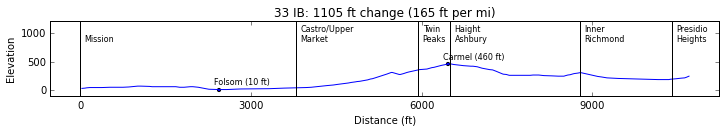

In [33]:
plot_fig2(('33','IB'), muni, neighs, streets, contours)

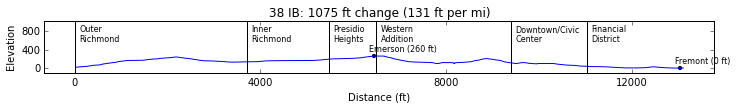

In [35]:
plot_fig2(('38','IB'), muni, neighs, streets, contours)

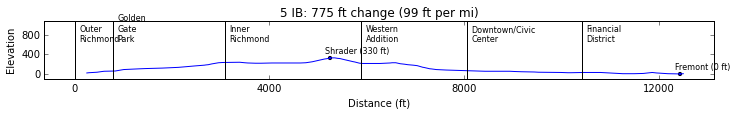

In [36]:
plot_fig2(('5','IB'), muni, neighs, streets, contours)

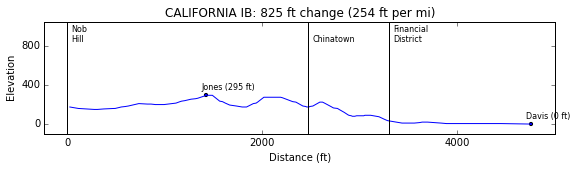

In [37]:
plot_fig2(('CALIFORNIA','IB'), muni, neighs, streets, contours)

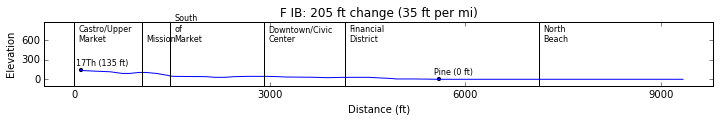

In [38]:
plot_fig2(('F','IB'), muni, neighs, streets, contours)

And that's it! The last 2 plots are interesting to compare because they are one of the hilliest (The California Cable car goes over Nob Hill and down into the Financial District) and the F (the street trolley that runs along Market St and Embarcadero). 